In [1]:
from sklearn.feature_extraction.text import CountVectorizer
from FeatureEngine.FeatureMethods import FeatureEngine
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
import numpy as np
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
#import shap

#Overview of unsupervised techniques in financial accounting auditing paper shared below. Within this notebook we've tested an autoencoder and isolation forest. What I have not considered testing is approaches that are defined in the paper as "grey literature", which are by definition not peer reviewed and may be experimental in nature. 
#https://essay.utwente.nl/79813/1/Lenderink_MA_EEMCS.pdf


#Note: The FeatureEngine is for TESTING ONLY, we'll need to pickle sklearn objects which means the methods as they are currentlly set-up in function featurizer won't handle pickling.
#https://stackoverflow.com/questions/28656736/using-scikits-labelencoder-correctly-across-multiple-programs


print(Path.cwd())

pathBase = str(Path.cwd())
cv = CountVectorizer()


#df1 = pd.read_csv(pathBase + "\Datasets\dataset.csv")

df = pd.read_csv(pathBase + "\Datasets\TeraSample.csv")


#categories = ['alt.atheism', 'soc.religion.christian','comp.graphics', 'sci.med']

#twenty_train = fetch_20newsgroups(subset='train', categories=categories, shuffle=True, random_state=42)
#venv guidance
#https://stackoverflow.com/questions/8921188/issue-with-virtualenv-cannot-activate
#https://janakiev.com/blog/jupyter-virtual-envs/
#https://towardsdatascience.com/the-art-of-effective-visualization-of-multi-dimensional-data-6c7202990c57
df['DEB_CRE_USD']

c:\Users\dylan.levine\Development\HCP Classification\HCP-Classification


0          231.39
1        13445.19
2         1919.60
3         -513.45
4       106963.20
          ...    
1995         6.20
1996     -9253.44
1997     -4225.00
1998      -189.00
1999        85.80
Name: DEB_CRE_USD, Length: 2000, dtype: float64

In [2]:
#Define DateEncode as basic features such as day of week, month int, and year int.
#Define groupencode as placing into buckets
#Define mapencode as mapping values to a higher-level grouping


#Define relavent fields to model and their associated data types and feature engineering methods
colDict = {
    "COMP_CODE": {"Type":"Categorical", "Method":"1hot"},
    "REF_KEY1":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_NR": {"Type":"ID", "Method":"N/A"},
    "PSTNG_DATE":{"Type":"Date", "Method":"DateEncode"},
    "CREATEDON":{"Type":"Date", "Method":"DateEncode"},
    "DOC_DATE":{"Type":"Date", "Method":"DateEncode"},
    "PROFIT_CTR":{"Type":"Categorical", "Method":"1hot"},
    "AC_DOC_TYP":{"Type":"Categorical", "Method":"1hot"},
    "POST_KEY":{"Type":"Categorical", "Method":"1hot"},
    "CREDITOR":{"Type":"Categorical", "Method":"MapEncode"},
    "NAME":{"Type":"Text", "Method":"Tokenize"},
    "GL_ACCOUNT":{"Type":"Categorical", "Method":"1hot"},
    "CUSTOMER":{"Type":"Categorical", "Method":"MapEncode"},
    "POSTXT":{"Type":"Text", "Method":"Tokenize"},
    "BIC_ZUSERNAM":{"Type":"Categorical", "Method":"MapEncode"},
    "ZBKTXT":{"Type":"Text", "Method":"Tokenize"},
    "ZTCODE":{"TYpe":"Categorical", "Method":"1hot"},
    "DEB_CRE_USD":{"Type":"Numerical", "Method":"GroupEncode"},
    "BIC_ZTERMPAY":{"Type":"Categorical", "Method":"1hot"},
    "MATL_GROUP":{"Type":"Categorical", "Method":"1hot"},
    "ACCNT_GRPV":{"Type":"Categorical", "Method":"1hot"}

}



#Set pandas datatypes for each field
df['COMP_CODE'] = df['COMP_CODE'].astype('object')
df['REF_KEY1'] = df['REF_KEY1'].astype('object')
df['AC_DOC_NR'] = df['AC_DOC_NR'].astype('object')
df['PSTNG_DATE'] = pd.to_datetime(df['PSTNG_DATE'].astype('object'), format="%Y%m%d")
df['CREATEDON'] = pd.to_datetime(df['CREATEDON'].astype('object'), format="%Y%m%d")
df['DOC_DATE'] = pd.to_datetime(df['DOC_DATE'].astype('object'), format="%Y%m%d")
df['PROFIT_CTR'] = df['PROFIT_CTR'].astype('object')
df['AC_DOC_TYP'] = df['AC_DOC_TYP'].astype('object')
df['POST_KEY'] = df['POST_KEY'].astype('object')
df['CREDITOR'] = df['CREDITOR'].astype('object')
df['NAME'] = df['NAME'].astype('object')
df['GL_ACCOUNT'] = df['GL_ACCOUNT'].astype('object')
df['CUSTOMER'] = df['CUSTOMER'].astype('object')
df['POSTXT'] = df['POSTXT'].astype('object')
df['BIC_ZUSERNAM'] = df['BIC_ZUSERNAM'].astype('object')
df['ZBKTXT'] = df['ZBKTXT'].astype('object')
df['ZTCODE'] = df['ZTCODE'].astype('object')
#df['DEB_CRE_USD'] = df['BIC_ZTERMPAY'].replace(',', '').astype(float)
df['DEB_CRE_USD'] = pd.to_numeric(df['DEB_CRE_USD'])
df['BIC_ZTERMPAY'] = df['BIC_ZTERMPAY'].astype('object')
df['MATL_GROUP'] = df['MATL_GROUP'].astype('object')
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].astype('object')



#Filter data for relavent rows
df = df[ (df.POST_KEY == 40) | (df.POST_KEY == 81) | (df.POST_KEY == 96) & (df.GL_ACCOUNT >= 40000000)]

#Get list of relavent fields
colSelect = list(colDict.keys())

df[colSelect]

df

,LOGSYS,COMP_CODE,COMP_CODE_T,FISCPER,FISCVARNT,AC_LEDGER,AC_DOC_NR,AC_DOC_LN,FISCPER3,PSTNG_DATE,...,COUNTRY,BI_TCOUNTRY,VM_HC_BLOCIND,BIC_ZCENPURB,ACCNT_GRPV,BI_ACCNT_TGRPV,VM_DEL_INDIC,ZDELBCK,BANKCTRY,BANKACCT
1,PEACLNT100,1003,Abbott Laboratories,2019009,K4,0L,5000182043,1,9,2019-09-30,...,IE,Ireland,?,?,Z001,Vendor (Legal Entity),?,?,IE,16392902
2,PEACLNT100,1003,Abbott Laboratories,2020001,K4,0L,5100010932,2,1,2020-01-17,...,US,USA,?,?,Z001,Vendor (Legal Entity),?,?,US,870512506
5,PEACLNT100,1003,Abbott Laboratories,2020004,K4,0L,5000071281,11,4,2020-04-16,...,US,USA,?,?,Z001,Vendor (Legal Entity),?,?,US,906000548
6,PEACLNT100,1003,Abbott Laboratories,2019012,K4,0L,1900086719,2,12,2019-12-30,...,US,USA,?,?,Z003,Invoicing Party,?,?,US,414128
7,PEACLNT100,1003,Abbott Laboratories,2019009,K4,0L,5100182522,2,9,2019-09-13,...,US,USA,?,?,Z001,Vendor (Legal Entity),?,?,US,7460554053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,PEACLNT100,1003,Abbott Laboratories,2019008,K4,0L,5000150718,1,8,2019-08-08,...,US,USA,?,?,Z001,Vendor (Legal Entity),?,?,US,3756241851
1989,PEACLNT100,1003,Abbott Laboratories,2020001,K4,0L,5100006439,2,1,2020-01-11,...,US,USA,?,?,Z001,Vendor (Legal Entity),?,?,US,870512506
1993,PEACLNT100,1003,Abbott Laboratories,2019009,K4,0L,5100190885,3,9,2019-09-26,...,US,USA,?,?,Z003,Invoicing Party,?,?,US,1459103106
1995,PEACLNT100,1003,Abbott Laboratories,2019006,K4,0L,5100110476,11,6,2019-06-05,...,US,USA,?,?,Z001,Vendor (Legal Entity),?,?,US,2426922602


In [3]:

#Clean and transform data

#Replaces all ? with numpy nan val
df = df[colSelect].replace("?", np.nan)

#For encoding purposes replaces nans with a related text identifier
df['REF_KEY1'] = df['REF_KEY1'].replace(np.nan, "nan_REF_KEY1")
df['CUSTOMER'] = df['CUSTOMER'].replace(np.nan, "nan_CUSTOMER")
df['MATL_GROUP'] = df['MATL_GROUP'].replace(np.nan, "nan_MATL_GROUP")
df['ACCNT_GRPV'] = df['ACCNT_GRPV'].replace(np.nan,"nan_ACCNT_GRPV") 

#Replaces
df.loc[df.BIC_ZUSERNAM != "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "USER"
df.loc[df.BIC_ZUSERNAM == "AUTOSYS", 'BIC_ZUSERNAM_BINARY'] = "SYSTEM"
df.loc[df.DOC_DATE == np.nan, 'DOC_DATE'] = df['PSTNG_DATE']
#df['DOC_DATE'].loc[df.DOC_DATE != np.nan] gets by filtered


df['textappend'] = df['NAME'].astype(str) +" "+ df['POSTXT'].astype(str) +" "+ df["ZBKTXT"].astype(str)

df

,COMP_CODE,REF_KEY1,AC_DOC_NR,PSTNG_DATE,CREATEDON,DOC_DATE,PROFIT_CTR,AC_DOC_TYP,POST_KEY,CREDITOR,...,POSTXT,BIC_ZUSERNAM,ZBKTXT,ZTCODE,DEB_CRE_USD,BIC_ZTERMPAY,MATL_GROUP,ACCNT_GRPV,BIC_ZUSERNAM_BINARY,textappend
1,1003,nan_REF_KEY1,5000182043,2019-09-30,2019-09-30,2019-09-30,12262,WE,81,10027697,...,2L ALINITY BTLE VALIDATION 50%,AUTOSYS,NaN,MB01,13445.19,24,nan_MATL_GROUP,Z001,SYSTEM,MERGON INTERNATIONAL 2L ALINITY BTLE VALIDATIO...
2,1003,EDIINV,5100010932,2020-01-17,2020-01-17,2020-01-16,12259,RE,81,10003556,...,NaN,AUTOSYS,NaN,MR1M,1919.60,23,nan_MATL_GROUP,Z001,SYSTEM,"EXPERIS US, INC. nan nan"
5,1003,nan_REF_KEY1,5000071281,2020-04-16,2020-04-16,2020-04-16,12071,WE,81,10033062,...,NaN,PAWELGS,NaN,MIGO_GR,348.00,23,Z1-102126,Z001,USER,SERACARE LIFE SCIENCES INC nan nan
6,1003,UPLOAD,1900086719,2019-12-30,2019-12-30,2019-10-03,12250,KR,40,30013196,...,NaN,SHARMSX116,2.02E+13,ZFII_INV_UPD_PGM,187.71,23,nan_MATL_GROUP,Z003,USER,RED WING SHOE STORE nan 2.02E+13
7,1003,EDIINV,5100182522,2019-09-13,2019-09-13,2019-09-12,12250,RE,81,10030946,...,NaN,AUTOSYS,NaN,MR1M,1115.28,23,nan_MATL_GROUP,Z001,SYSTEM,HIREGENICS INC nan nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1003,nan_REF_KEY1,5000150718,2019-08-08,2019-08-08,2019-08-08,12071,WE,81,10009414,...,NaN,BERGESX6,NaN,MIGO_GR,980.00,13,Z1-102110,Z001,USER,MICROGENICS CORPORATION nan nan
1989,1003,EDIINV,5100006439,2020-01-11,2020-01-11,2020-01-09,12082,RE,81,10003556,...,NaN,AUTOSYS,NaN,MR1M,969.36,23,nan_MATL_GROUP,Z001,SYSTEM,"EXPERIS US, INC. nan nan"
1993,1003,OCRINV,5100190885,2019-09-26,2019-09-26,2019-09-25,12250,RE,40,30086991,...,NaN,C_ERP_BRAINW,NaN,MIRO,112.00,23,nan_MATL_GROUP,Z003,USER,LIFE TECHNOLOGIES CORPORATION nan nan
1995,1003,OCRINV,5100110476,2019-06-05,2019-06-05,2019-06-03,12071,RE,40,10002390,...,NaN,C_ERP_BRAINW,NaN,MIRO,6.20,24,nan_MATL_GROUP,Z001,USER,MAINE STANDARDS COMPANY LLC nan nan


In [4]:
modelVals2 = FeatureEngine(df)

modelVals2.transformDateTime("PSTNG_DATE","Days")

modelVals2.df

modelVals2.df.to_csv(pathBase + "\Datasets\csvoutput.csv")

(-50000.0, 50000.0)

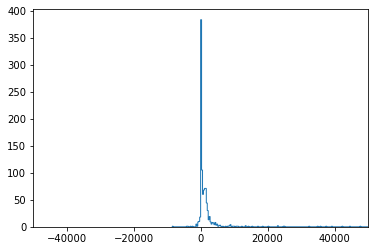

In [4]:


plt.hist(df['DEB_CRE_USD'],bins='auto', histtype='step')
plt.xlim(-50000,50000)

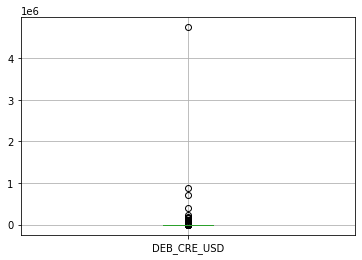

In [5]:
df.boxplot(column=['DEB_CRE_USD'])

In [6]:
modelVals = FeatureEngine(df)

modelVals.oneHotEncodeLabels(["REF_KEY1","PROFIT_CTR","AC_DOC_TYP","POST_KEY","GL_ACCOUNT","ZTCODE", "BIC_ZTERMPAY", "MATL_GROUP", "ACCNT_GRPV"])


#modelVals.oneHotEncodeLabels("BIC_ZTERMPAY")

modelVals.df

,COMP_CODE,AC_DOC_NR,PSTNG_DATE,CREATEDON,DOC_DATE,CREDITOR,NAME,CUSTOMER,POSTXT,BIC_ZUSERNAM,...,MATL_GROUP_999999,MATL_GROUP_Z1-102110,MATL_GROUP_Z1-102126,MATL_GROUP_Z1-102130,MATL_GROUP_Z1-134170,MATL_GROUP_Z1-182198,MATL_GROUP_nan_MATL_GROUP,ACCNT_GRPV_Z001,ACCNT_GRPV_Z003,ACCNT_GRPV_Z004
1,1003,5000182043,2019-09-30,2019-09-30,2019-09-30,10027697,MERGON INTERNATIONAL,nan_CUSTOMER,2L ALINITY BTLE VALIDATION 50%,AUTOSYS,...,0,0,0,0,0,0,1,1,0,0
2,1003,5100010932,2020-01-17,2020-01-17,2020-01-16,10003556,"EXPERIS US, INC.",nan_CUSTOMER,NaN,AUTOSYS,...,0,0,0,0,0,0,1,1,0,0
5,1003,5000071281,2020-04-16,2020-04-16,2020-04-16,10033062,SERACARE LIFE SCIENCES INC,50296854,NaN,PAWELGS,...,0,0,1,0,0,0,0,1,0,0
6,1003,1900086719,2019-12-30,2019-12-30,2019-10-03,30013196,RED WING SHOE STORE,nan_CUSTOMER,NaN,SHARMSX116,...,0,0,0,0,0,0,1,0,1,0
7,1003,5100182522,2019-09-13,2019-09-13,2019-09-12,10030946,HIREGENICS INC,nan_CUSTOMER,NaN,AUTOSYS,...,0,0,0,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,1003,5000150718,2019-08-08,2019-08-08,2019-08-08,10009414,MICROGENICS CORPORATION,50116128,NaN,BERGESX6,...,0,1,0,0,0,0,0,1,0,0
1989,1003,5100006439,2020-01-11,2020-01-11,2020-01-09,10003556,"EXPERIS US, INC.",nan_CUSTOMER,NaN,AUTOSYS,...,0,0,0,0,0,0,1,1,0,0
1993,1003,5100190885,2019-09-26,2019-09-26,2019-09-25,30086991,LIFE TECHNOLOGIES CORPORATION,nan_CUSTOMER,NaN,C_ERP_BRAINW,...,0,0,0,0,0,0,1,0,1,0
1995,1003,5100110476,2019-06-05,2019-06-05,2019-06-03,10002390,MAINE STANDARDS COMPANY LLC,nan_CUSTOMER,NaN,C_ERP_BRAINW,...,0,0,0,0,0,0,1,1,0,0


In [7]:
#In addition to frequent words we should also specifically get words or phrases that are specific to HCP selections https://kavita-ganesan.com/extracting-keywords-from-text-tfidf/#.YBT34KdKhPY. To also evaluate if we should use TD-IDF vs. standard count vectorizer

#To get all root words, for example https://medium.com/datadriveninvestor/unsupervised-outlier-detection-in-text-corpus-using-deep-learning-41d4284a04c8

#To add a feature that counts the # of transacations by vendor

vectdf = modelVals.concatVector('textappend',1,2,min_df=0.20,max_df=0.90) 

modelVals.df



,index,COMP_CODE,AC_DOC_NR,PSTNG_DATE,CREATEDON,DOC_DATE,CREDITOR,NAME,CUSTOMER,POSTXT,...,sigma aldrich,standards,standards company,staples,staples advantage,sterigenics,sterigenics llc,technologies,vwr,vwr scientific
0,1,1003,5000182043,2019-09-30,2019-09-30,2019-09-30,10027697,MERGON INTERNATIONAL,nan_CUSTOMER,2L ALINITY BTLE VALIDATION 50%,...,0,0,0,0,0,0,0,0,0,0
1,2,1003,5100010932,2020-01-17,2020-01-17,2020-01-16,10003556,"EXPERIS US, INC.",nan_CUSTOMER,NaN,...,0,0,0,0,0,0,0,0,0,0
2,5,1003,5000071281,2020-04-16,2020-04-16,2020-04-16,10033062,SERACARE LIFE SCIENCES INC,50296854,NaN,...,0,0,0,0,0,0,0,0,0,0
3,6,1003,1900086719,2019-12-30,2019-12-30,2019-10-03,30013196,RED WING SHOE STORE,nan_CUSTOMER,NaN,...,0,0,0,0,0,0,0,0,0,0
4,7,1003,5100182522,2019-09-13,2019-09-13,2019-09-12,10030946,HIREGENICS INC,nan_CUSTOMER,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1015,1986,1003,5000150718,2019-08-08,2019-08-08,2019-08-08,10009414,MICROGENICS CORPORATION,50116128,NaN,...,0,0,0,0,0,0,0,0,0,0
1016,1989,1003,5100006439,2020-01-11,2020-01-11,2020-01-09,10003556,"EXPERIS US, INC.",nan_CUSTOMER,NaN,...,0,0,0,0,0,0,0,0,0,0
1017,1993,1003,5100190885,2019-09-26,2019-09-26,2019-09-25,30086991,LIFE TECHNOLOGIES CORPORATION,nan_CUSTOMER,NaN,...,0,0,0,0,0,0,0,1,0,0
1018,1995,1003,5100110476,2019-06-05,2019-06-05,2019-06-03,10002390,MAINE STANDARDS COMPANY LLC,nan_CUSTOMER,NaN,...,0,1,1,0,0,0,0,0,0,0


In [8]:


modelVals.outputFeatures()
modelVals.fit_transform()

dftrain = modelVals.dfscaled


In [9]:
dftrain

dftrain.to_csv(pathBase + "\Datasets\csvoutput.csv")

In [10]:
dftrainnumpy = dftrain.to_numpy()

dftrainnumpy.shape

(1020, 209)

In [11]:
from sklearn.ensemble import IsolationForest

seed = 12345
ntrees = 100
quantile = 0.95

x = IsolationForest(random_state=seed, contamination=(1-quantile),
                    n_estimators=ntrees, behaviour="new").fit(dftrainnumpy)

iso_predictions = x.predict(dftrainnumpy)
iso_score = x.score_samples(dftrainnumpy)


sk_predictions = pd.DataFrame({
    "predicted_class": list(map(lambda x: 1*(x == -1), iso_predictions)),
    "predict": -iso_score
})

sk_predictions


,predicted_class,predict
0,0,0.345673
1,0,0.335012
2,0,0.402803
3,0,0.412374
4,0,0.336283
...,...,...
1015,0,0.403388
1016,0,0.340854
1017,0,0.430910
1018,1,0.449803


In [13]:
import shap
#Exaplin  features
#https://stats.stackexchange.com/questions/404017/how-to-get-top-features-that-contribute-to-anomalies-in-isolation-forest/451518#451518

X_explain = dftrainnumpy
shap_values = shap.TreeExplainer(x).shap_values(X_explain)
shap.summary_plot(shap_values, X_explain)



ModuleNotFoundError: No module named 'shap'

In [19]:
from sklearn.neural_network import MLPRegressor

#https://github.com/h2oai/h2o-tutorials/blob/master/tutorials/isolation-forest/isolation-forest.ipynb to utilize isolation-forest for binary classification

auto_encoder = MLPRegressor(hidden_layer_sizes=(300,150,300,),solver='lbfgs', verbose=True) #according to scikit learn documentation lbfgs is better for smaller datasets. To change to adam method once we get larger dataset

auto_encoder.fit(dftrainnumpy, dftrainnumpy)

MLPRegressor(hidden_layer_sizes=(1500, 750, 1500), solver='lbfgs', verbose=True)

In [20]:
predicted_vectors = auto_encoder.predict(dftrainnumpy)

print(predicted_vectors)
auto_encoder.score(predicted_vectors, dftrainnumpy)

[[-3.06555796e-02  9.99146629e-01  1.67801134e-03 ...  1.28367998e-02
   1.23863432e-02 -2.08860839e-02]
 [-3.21703455e-03  1.00936788e+00 -3.06457555e-03 ...  3.48233583e-03
   3.37069056e-03 -5.16206139e-03]
 [-2.16933945e-03  9.91343312e-01  4.05208981e-03 ... -3.72584982e-03
  -5.62716861e-03  4.73112140e-03]
 ...
 [-2.25275318e-02 -7.94929504e-03  9.95046210e-01 ...  1.05769084e+00
   1.20138884e-02  2.18811878e-02]
 [ 6.73366643e-04  1.01149183e+00 -7.52285771e-03 ...  9.12586101e-03
  -1.57637578e-02  2.09310626e-03]
 [ 1.50743465e-02  1.00911197e+00 -1.36352103e-02 ...  5.42886080e-03
  -6.06336105e-03  1.00784611e-03]]


0.857107804358801

In [21]:
pd.DataFrame(auto_encoder.loss).plot()

#max loss reached at 30th iteration

ValueError: DataFrame constructor not properly called!

In [22]:
from scipy.spatial.distance import cosine

def key_consine_similarity(tupple):
    return tupple[1]

def get_computed_similarities(vectors, predicted_vectors, reverse=False):
    data_size = len(dftrain) #was df train
    cosine_similarities = []
    for i in range(data_size):
        cosine_sim_val = (1 - cosine(vectors[i], predicted_vectors[i]))
        cosine_similarities.append((i, cosine_sim_val))

    return sorted(cosine_similarities, key=key_consine_similarity, reverse=reverse)

def display_top_n(sorted_cosine_similarities, n=5):
    for i in range(n):
        index, consine_sim_val = sorted_cosine_similarities[i]
        print('Record: ', modelVals.df.iloc[index])   #was dftrain
        print('Cosine Sim Val :', consine_sim_val)
        print('---------------------------------')

sorted_cosine_similarities = get_computed_similarities(vectors=dftrainnumpy, predicted_vectors=predicted_vectors)

display_top_n(sorted_cosine_similarities=sorted_cosine_similarities)

Record:  index                              171
COMP_CODE                         1003
AC_DOC_NR                   1900026691
PSTNG_DATE         2020-04-27 00:00:00
CREATEDON          2020-04-27 00:00:00
                          ...         
sterigenics                          0
sterigenics llc                      0
technologies                         0
vwr                                  0
vwr scientific                       0
Name: 84, Length: 223, dtype: object
Cosine Sim Val : 0.9651745620794653
---------------------------------
Record:  index                              294
COMP_CODE                         1003
AC_DOC_NR                   5000014342
PSTNG_DATE         2020-01-23 00:00:00
CREATEDON          2020-01-23 00:00:00
                          ...         
sterigenics                          0
sterigenics llc                      0
technologies                         0
vwr                                  0
vwr scientific                       0
Name: 141, Length

In [7]:
modelVals.reverse_transform()

modelVals.dfscaled

,EntityName_Acura,EntityName_Alfa Romeo,EntityName_Aston Martin,EntityName_Audi,EntityName_Austin,EntityName_BMW,EntityName_Bentley,EntityName_Buick,EntityName_Cadillac,EntityName_Chevrolet,...,EntityName_Saab,EntityName_Saturn,EntityName_Scion,EntityName_Subaru,EntityName_Suzuki,EntityName_Tesla,EntityName_Toyota,EntityName_Volkswagen,EntityName_Volvo,EntityName_labeled
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,55.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.0
998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [ ]:
#Select columns, replace "?" with numpy nan type and initialize FeatureEngine object

#Note: Any vendor number that doesn't start with an integer is interco. We can filter on that.
#Note: The AC_DOC_NR is the accounting doc (i.e. the payment invoice doc)
#SQL query paramas:
#Account tyep is prefiltered as S, and S = G/L account type.
#Posting data 1/1/2019 - 10/31/2020
#Company code = 1000 or 1003, which is all US based companies
#Division = ADD

#Note: Timing between doc date and clearing date (i.e. # of days to clear). But a clearing binary flag isn't useful. CLEAR_DATE is the date it was cleared/paid. Note: Not all records are going to have a days

#Note: Should we aggregate/groupby the DOC ln's together or keep them separate

#Post keys = 31, 32, 34, 21, 22, 24, 29 and 39 are the relavent post-keys, so we can likely filter out the rest.
#ACCNT_GRPV = 

#Vendors can have different payment terms accross different entities. So the vendor number can be the same, but have different terms across different entities.

#AC_DOC_NR-COMP_CODE probablly isn't needed, invoice doc nr should be unique. But we do want AC_DOC_NR-Fiscalyear because fiscal years rotate doc_nrs.

#MATL_GROUP helps to identify the "Type" of material that we're purchasing at a grouped level. 

#DOC_DATE is adjustable by the user, #posting is the accounting period, #Created on is system generated as it's just litterally when the doc was started. Doc_date and posting date can be a relavent relationship (i.e. maybe days difference between doc and posting?).

#You can have the same vendor with different attributes.
#GL_Account mapping to HCP relavent transacations. Creating a feature possiblly off of that? But we don't want to run into a situation where we're not capturing trnasacations outside of those G/Ls. 
#To create a feature based off of whether or not a vendor has had a historical HCP transacation.  

#Michael to possiblly look into external Sunshine Act reporting databases?

#To do a merge between the sample Tera data and the full vendor master data using [vendor number - company code]. KEy fields in the vendor master = "Name (i.e. does it contai ngovernment, hospital, etc)", vnedor name, vnedor with duplicate address or attributes that should be unique, ID_XCPD is a one time indicate, BIC_ZTERMPAY (different from what is on the invoice) -- maybe add a flag checking if they are different, 

#To possiblly add a number of occurrences a vendor has been used as a feature?

#MCC code one-hot encodde

#REF_KEY1 fill "?" with nan
#Do we have a product # vs product description?
#Classify BIC_ZUSERNAM as manual or not depending on if posted by AUTOSYS
#Tokenize appended text fields of NAME, POSTXT, ZBTXT
#Feature ideas, calculate diff of posting and created?
#n_samples > n_features ** 2 (i.e. rows > columns.count squared)

#If we don't have labeled values then maybe use PYOD for unsupervised detection? https://pyod.readthedocs.io/en/latest/
